<a href="https://colab.research.google.com/github/sammeee/Emotion-Detection/blob/main/sad_and_happy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                 **Emotion Detection**

### We fetched about 186 images of happy and sad people from Google image. Next, we build and train our model on this data. On evaluation, the model gives a Precision score of 0.79 and a recall score of 1.


### We can get better prediction scores by training the model on a larger data and using data augmentation.

## Import the Dependencies

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import imghdr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

## Import the Dataset

In [ ]:
# First, we fetched the images from Google image and save them in a zipped folder on Kaggle.
# Next, we download the data from Kaggle and unzip it.

os.environ['KAGGLE_USERNAME'] = 'zammie'
os.environ['KAGGLE_KEY'] = '1e6482762eeaa21285681d9b5b302bb9'
!kaggle datasets download -d zammie/dataz-file

dataz-file.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/dataz-file.zip', 'r') as zip:
  zip.extractall()

In [ ]:
data_dir = '/content/dataz'

### Data Cleaning
##### Remove dodgy images

In [ ]:
img_exts = ['jpg', 'jpeg', 'png', 'bmp']

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    img_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(img_path)
      tip = imghdr.what(img_path)
      if tip not in img_exts:
        print('Image not in ext list {}'.format(img_path))
        os.remove(img_path)
    except Exception as e:
      print('Issue with image {}'.format(img_path))

Image not in ext list /content/dataz/happy/guilherme-stecanella-375176-unsplash.jpg
Image not in ext list /content/dataz/happy/traitshappypeople.jpg
Image not in ext list /content/dataz/happy/220px-Happy_People_A_Year_in_the_Taiga_poster.jpg
Image not in ext list /content/dataz/happy/56f455011e0000b300705475.jpeg
Image not in ext list /content/dataz/happy/1200px-Happy_People.jpg
Image not in ext list /content/dataz/sad/39843138-sad-man.jpg
Image not in ext list /content/dataz/sad/50740738-sad-people-s-portraits.jpg
Image not in ext list /content/dataz/sad/depressed-man-studio-shot-260nw-404652526.jpg
Image not in ext list /content/dataz/sad/crying-sad.gif
Image not in ext list /content/dataz/sad/766x415_Depression_vs_Sadness.jpg
Image not in ext list /content/dataz/sad/african-american-depressive-sad-broken-260nw-475790911.jpg


In [ ]:
img = cv2.imread('/content/dataz/happy/05-12-21-happy-people.jpg')

In [ ]:
img.shape

(880, 1400, 3)

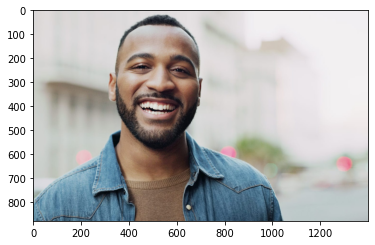

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Load Data/ EDA

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)   # building data pipeline

Found 186 files belonging to 2 classes.


In [ ]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
data_iterator = data.as_numpy_iterator()  # allows us to access data pipeline

In [ ]:
batch = data_iterator.next()  # actually accessing data pipeline

In [ ]:
len(batch)

2

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
category = ['happy', 'sad']

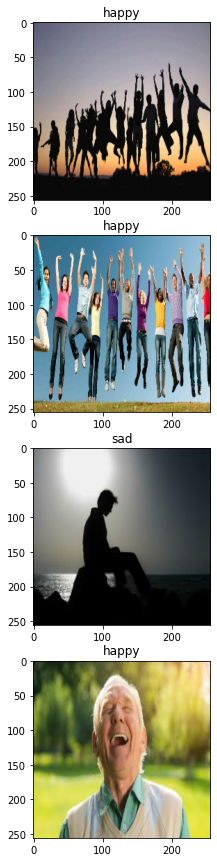

In [ ]:
fig, ax = plt.subplots(4, figsize=(15,15))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(category[batch[1][idx]])

### Preprocess Data

In [ ]:
batch[0].min()

0.0

In [ ]:
batch[0].max()

255.0

In [ ]:
data = data.map(lambda x, y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
scaled_batch = data.as_numpy_iterator().next()

In [ ]:
scaled_batch[0].max()

1.0

In [ ]:
scaled_batch[1]

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0], dtype=int32)

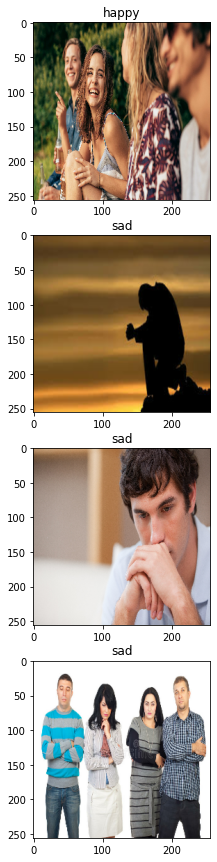

In [ ]:
fig, ax = plt.subplots(4, figsize=(15,15))
for idx, img in enumerate(scaled_batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(category[scaled_batch[1][idx]])

In [ ]:
len(data)

6

In [ ]:
train_size = int(len(data)*0.6)
val_size = int(len(data)*0.3) + 1
test_size = int(len(data)*0.1) + 1

In [ ]:
train_size, val_size, test_size

(3, 2, 1)

In [ ]:
train_size + val_size + test_size

6

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### Building a Model

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, (3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

### Train the Model

In [ ]:
logdir = 'logs'

In [ ]:
tensorflow_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorflow_callbacks])

Epoch 1/20
3/3 [==============================] - 30s 10s/step - loss: 0.7247 - accuracy: 0.4479 - val_loss: 0.6847 - val_accuracy: 0.6094
Epoch 2/20
3/3 [==============================] - 22s 7s/step - loss: 0.6833 - accuracy: 0.5833 - val_loss: 0.7707 - val_accuracy: 0.4375
Epoch 3/20
3/3 [==============================] - 21s 7s/step - loss: 0.6980 - accuracy: 0.5729 - val_loss: 0.6850 - val_accuracy: 0.5469
Epoch 4/20
3/3 [==============================] - 27s 9s/step - loss: 0.7022 - accuracy: 0.5104 - val_loss: 0.6621 - val_accuracy: 0.5625
Epoch 5/20
3/3 [==============================] - 23s 7s/step - loss: 0.6137 - accuracy: 0.6562 - val_loss: 1.4716 - val_accuracy: 0.4844
Epoch 6/20
3/3 [==============================] - 21s 7s/step - loss: 0.9279 - accuracy: 0.5312 - val_loss: 0.6711 - val_accuracy: 0.4688
Epoch 7/20
3/3 [==============================] - 26s 9s/step - loss: 0.6762 - accuracy: 0.5521 - val_loss: 0.6816 - val_accuracy: 0.5781
Epoch 8/20
3/3 [=================

In [ ]:
history_df = pd.DataFrame(history.history)

## Learning from the Learning Curves

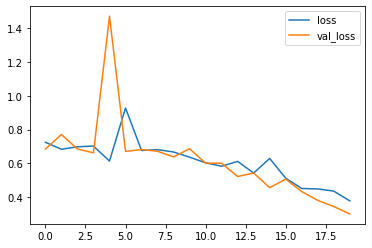

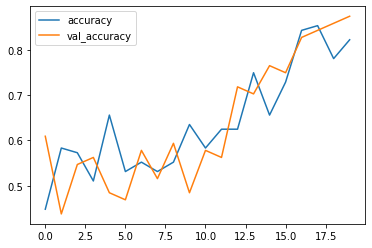

In [ ]:
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

### Evaluation of the Model

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)

  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [ ]:
print('precision: {}, recall: {}, binary acc: {}'.format(pre.result().numpy(),re.result().numpy(),acc.result().numpy()))

precision: 0.7894737124443054, recall: 1.0, binary acc: 0.8461538553237915


### Running a Test on the Model

##### Here, we fetched random images of a sad person and a happy person from Google image. The model has not seen the images before.

In [ ]:
imgs = cv2.imread('/content/loser.jpg')

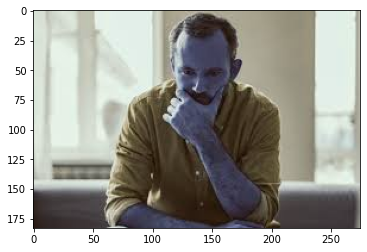

In [ ]:
plt.imshow(imgs)
plt.show()

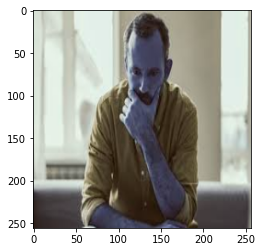

In [ ]:
resize_imgs = tf.image.resize(imgs, (256,256))
plt.imshow(resize_imgs.numpy().astype(int))
plt.show()

In [ ]:
scaled_imgs = np.expand_dims(resize_imgs/255,0)

In [ ]:
yhat = model.predict(scaled_imgs)

1/1 [==============================] - 0s 70ms/step


In [ ]:
yhat

array([[0.5990324]], dtype=float32)

In [ ]:
if yhat > 0.5:
  print('sad')
else:
  print('happy')

sad


In [ ]:
img = cv2.imread('/content/winner.jpg')

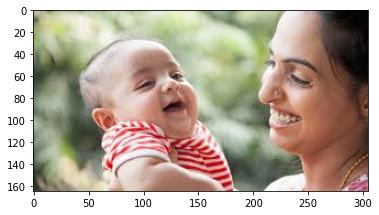

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))

In [ ]:
scaled_img = np.expand_dims(resize/255,0)

In [ ]:
yhat = model.predict(scaled_img)

1/1 [==============================] - 0s 58ms/step


In [ ]:
yhat

array([[0.4606439]], dtype=float32)

In [ ]:
if yhat > 0.5:
  print('sad')
else:
  print('happy')

happy


### Saving Model

In [ ]:
model.save(os.path.join('model', 'happy_and_sad.h5'))

### Re-using Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
new_model = load_model(os.path.join('model', 'happy_and_sad.h5'))

In [ ]:
new_model.predict(scaled_img)

1/1 [==============================] - 0s 173ms/step


array([[0.4606439]], dtype=float32)